In [ ]:
import pandas as pd
import optuna
import numpy as np
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict # ใช้ StratifiedKFold เพื่อจัดการ Imbalance

# --- 1. โหลดข้อมูล (เหมือนเดิม) ---
try:
    data_train_full = pandas.read_csv('../data/salary.train.processed.csv').set_index('id')
except FileNotFoundError:
    print("Error: ไม่พบไฟล์ salary.train.processed.csv กรุณาตรวจสอบ path")
    # exit()

X_full = data_train_full.drop(['label'], axis='columns')
y_full = data_train_full['label']

print(f"ใช้ข้อมูลเทรนทั้งหมด {len(y_full)} records สำหรับการจูน (K-Fold CV)")

# --- 2. สร้างฟังก์ชัน Objective (หัวใจของ Optuna) ---

def objective(trial):
    """
    ฟังก์ชันนี้ถูกปรับปรุงให้จูน C, penalty, และหา Best Threshold ภายใน Cross-Validation
    """

    # 1. กำหนดช่วงของพารามิเตอร์
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)

    # จูน class_weight (เพื่อความยืดหยุ่น แทนที่จะใช้แค่ 'balanced')
    # กำหนด weight_for_class_1 ตั้งแต่ 1 (unbalanced) ถึง 5 (heavily favoring minority class)
    weight_for_class_1 = trial.suggest_float('weight_for_class_1', 1.0, 5.0)
    class_weight = {0: 1.0, 1: weight_for_class_1}

    # 2. สร้าง Pipeline และ K-Fold Strategy
    pipeline_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(
            C=C,
            penalty=penalty,
            l1_ratio=l1_ratio,
            solver='saga',
            class_weight=class_weight, # 👈 ใช้ class_weight ที่จูนได้
            random_state=42,
            max_iter=5000,
            n_jobs=-1
        ))
    ])
    
    # 3. ประเมินผลด้วย Cross-validation และรวบรวม Probabilities
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # ใช้ cross_val_predict เพื่อให้ได้ Probabilities ของทุกจุดข้อมูล (OOF)
    y_probs = cross_val_predict(
        pipeline_lr, 
        X_full, 
        y_full, 
        cv=cv, 
        method='predict_proba', # 👈 ให้คืนค่าความน่าจะเป็น
        n_jobs=-1
    )[:, 1] # เลือกเฉพาะความน่าจะเป็นของคลาส 1

    # 4. ค้นหา Best Threshold ภายใน Trial
    thresholds = np.linspace(0.01, 0.99, 100)
    best_f1_in_trial = -1
    
    for t in thresholds:
        # ทำนายคลาสด้วย Threshold 't'
        y_pred_t = (y_probs >= t).astype(int)
        
        # คำนวณ F1 Score (weighted)
        f1_t = sklearn.metrics.f1_score(y_full, y_pred_t, average='weighted')
        
        if f1_t > best_f1_in_trial:
            best_f1_in_trial = f1_t
            
    # เก็บ Best Threshold ไว้ใน Trial (เป็น User Attribute)
    trial.set_user_attr("best_threshold", thresholds[np.argmax([sklearn.metrics.f1_score(y_full, (y_probs >= t).astype(int), average='weighted') for t in thresholds])])

    # 5. คืนค่า F1 เฉลี่ยสูงสุดที่พบใน Trial นี้
    return best_f1_in_trial

# --- 3. เริ่มการค้นหา (Study) ---

print("\nกำลังเริ่มการค้นหาพารามิเตอร์และ Threshold สำหรับ Logistic Regression ด้วย Optuna...")

pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)

study.optimize(
    objective, 
    n_trials=50, 
    show_progress_bar=True
)

# --- 4. แสดงผลลัพธ์ ---

print("\n--- Optuna ค้นหาเสร็จสิ้น! ---")

print("พารามิเตอร์ที่ดีที่สุด (Best Model Hyperparameters):")
print(study.best_params)
print(f"\nThreshold ที่ดีที่สุด (Best Threshold): {study.best_trial.user_attrs['best_threshold']:.4f}")
print(f"\nF1-Weighted ที่ดีที่สุด (จากการ CV): {study.best_value:.6f}")

# --- 5. (ขั้นตอนต่อไป) เทรนโมเดลสุดท้ายและประเมินผลบน Test Set ---

print("\nกำลังเทรน Pipeline สุดท้ายด้วยพารามิเตอร์ที่ดีที่สุด...")

# ดึงพารามิเตอร์ที่ดีที่สุดมา
best_lr_params = study.best_params
best_threshold = study.best_trial.user_attrs['best_threshold']

# สร้าง class_weight สำหรับโมเดลสุดท้าย
final_class_weight = {0: 1.0, 1: best_lr_params.get('weight_for_class_1')}

# สร้าง Pipeline สุดท้าย
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        C=best_lr_params.get('C'),
        penalty=best_lr_params.get('penalty'),
        l1_ratio=best_lr_params.get('l1_ratio'),
        solver='saga',
        class_weight=final_class_weight, # 👈 ใช้ class_weight ที่จูนได้
        random_state=42,
        max_iter=5000,
        n_jobs=-1
    ))
])

# เทรน Pipeline สุดท้ายด้วยข้อมูล "ทั้งหมด" (X_full, y_full)
final_pipeline.fit(X_full, y_full)

print("เทรนโมเดลสุดท้ายเสร็จสิ้น! กำลังประเมินผลบน Test Set...")

# โหลดข้อมูล Test
data_test_lr = pandas.read_csv('../data/salary.test.processed.csv').set_index('id')
X_test = data_test_lr.drop(['label'], axis='columns')
y_test = data_test_lr['label']

# ทำนาย Probabilities บน Test Set
y_probs_test = final_pipeline.predict_proba(X_test)[:, 1]

# ทำนายผลด้วย Best Threshold
y_pred_final = (y_probs_test >= best_threshold).astype(int)

# แสดงผลลัพธ์บน Test Set
print("\nLogistic Regression (Optuna-Tuned + Best Threshold) Confusion Matrix:")
print(sklearn.metrics.confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_final
))

report_scores_lr = sklearn.metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred_final,
    digits=6,
    output_dict=True
)
df_score_lr = pandas.DataFrame(report_scores_lr).transpose()
print("\nLogistic Regression (Optuna-Tuned + Best Threshold) Report:")
print(df_score_lr)

In [11]:
pos = {step: (0, -i) for i, step in enumerate(steps)}


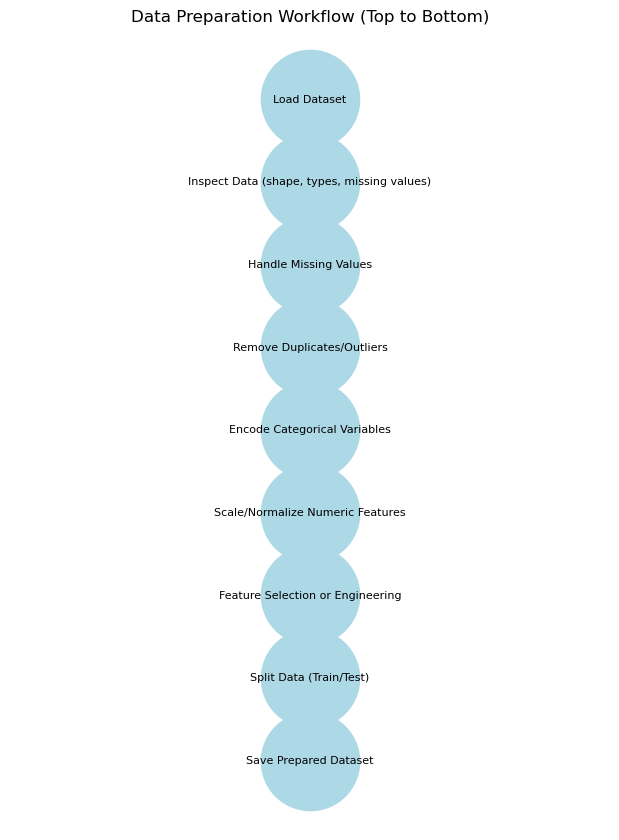

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

steps = [
    "Load Dataset",
    "Inspect Data (shape, types, missing values)",
    "Handle Missing Values",
    "Remove Duplicates/Outliers",
    "Encode Categorical Variables",
    "Scale/Normalize Numeric Features",
    "Feature Selection or Engineering",
    "Split Data (Train/Test)",
    "Save Prepared Dataset"
]

G = nx.DiGraph()
for i in range(len(steps)-1):
    G.add_edge(steps[i], steps[i+1])

# Manually position top→bottom
pos = {step: (0, -i) for i, step in enumerate(steps)}

plt.figure(figsize=(6, 8))
nx.draw(G, pos, with_labels=True, node_size=5000, node_color="lightblue",
        font_size=8, arrows=True, arrowsize=15)
plt.title("Data Preparation Workflow (Top to Bottom)")
plt.axis("off")
plt.show()


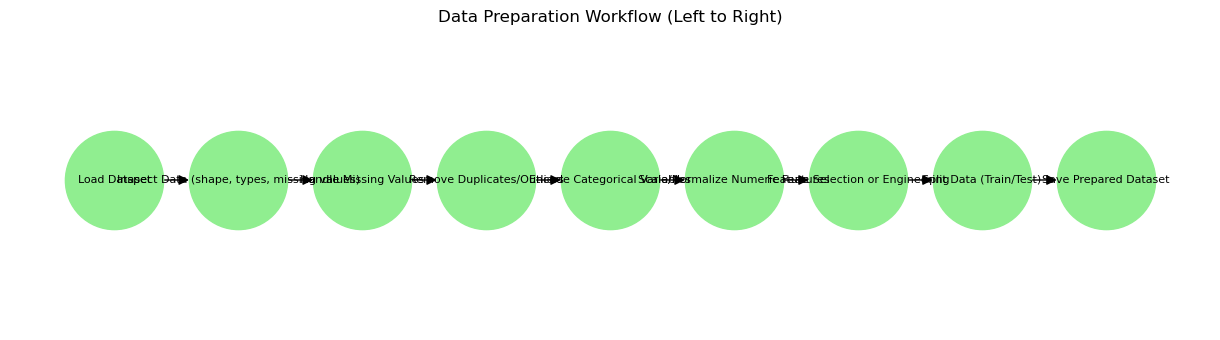

In [13]:
pos = {step: (i, 0) for i, step in enumerate(steps)}
import matplotlib.pyplot as plt
import networkx as nx

steps = [
    "Load Dataset",
    "Inspect Data (shape, types, missing values)",
    "Handle Missing Values",
    "Remove Duplicates/Outliers",
    "Encode Categorical Variables",
    "Scale/Normalize Numeric Features",
    "Feature Selection or Engineering",
    "Split Data (Train/Test)",
    "Save Prepared Dataset"
]

G = nx.DiGraph()
for i in range(len(steps)-1):
    G.add_edge(steps[i], steps[i+1])

# Manually position left→right
pos = {step: (i, 0) for i, step in enumerate(steps)}

plt.figure(figsize=(12, 3))
nx.draw(G, pos, with_labels=True, node_size=5000, node_color="lightgreen",
        font_size=8, arrows=True, arrowsize=15)
plt.title("Data Preparation Workflow (Left to Right)")
plt.axis("off")
plt.show()
